# Cricket Audio Analysis and Strike Detection
    Deepti Mahesh, 10-May-2020

In [23]:
import cv2
import numpy as np
import imutils
import matplotlib.pyplot as plt
import pandas as pd
import os
import librosa
import scipy
import csv

from scipy.io.wavfile import read, write  # Deal with audio files
from scipy.signal import find_peaks
from IPython.display import Audio  # Display inline media for playing audio files

%matplotlib inline

## Video Inputs


In [11]:
from IPython.display import Video

Video("../data/11.mp4")

## Audio Extraction

* Insert the corresponding file_names in `< >` to run command

In [12]:
import subprocess

cmd = "ffmpeg -i <Insert Video I/P> -ab 160k -ac 2 -ar 44100 -vn <Destination Audio O/P>"
var = subprocess.call(cmd, shell=True)

In [22]:
sound_file = '../data/audio3.wav' # Example audio
Audio(sound_file, autoplay=True)

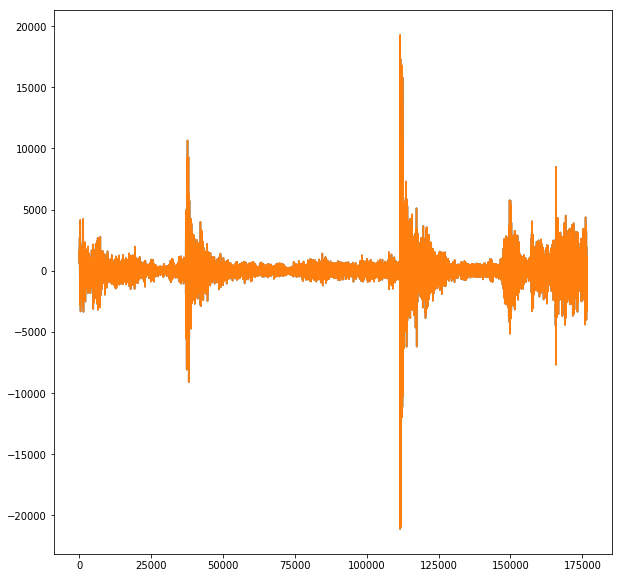

In [25]:
rate, audio = read('../data/audio3.wav')
plt.figure(figsize=(10,10))
plt.plot(audio)
plt.show()

## Smoothening, Removing Noise

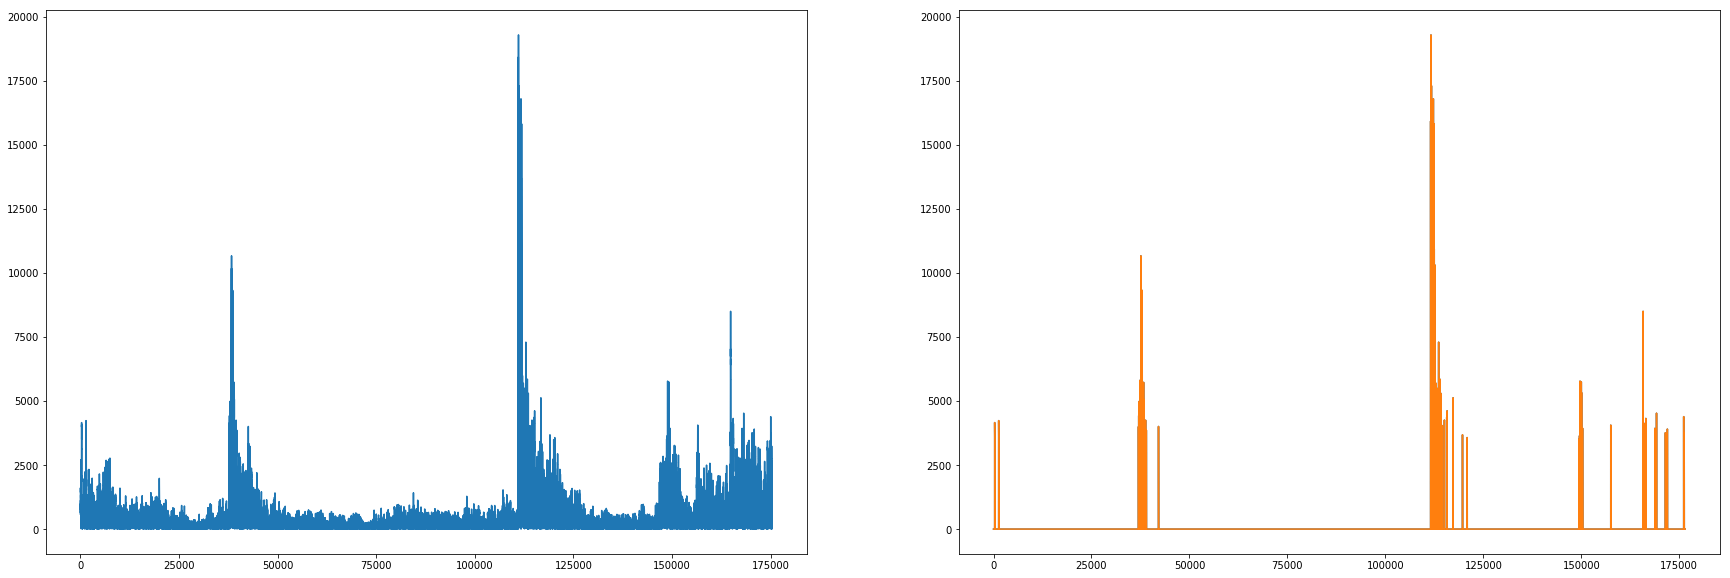

In [26]:
plt.figure(figsize=(30,10))

ax1 = plt.subplot(121)
ax1.plot(audio[audio>0])
X = scipy.fft.fft(audio)
X[X<7000] = 0  # Removing low frequency noise
audio_defft = np.real(scipy.fft.ifft(np.real(X)))

ax2 = plt.subplot(122)
ax2.plot(audio_defft)

plt.show()

## Peak Detection
* We try various methods for peak detection and find that inbuilt scipy method performs satisfactorily with respect to our needs. With sufficient distance established between the peaks using the `distance` paramenter of `find_peaks` method we extract a good number of windows from each audio sample/input.

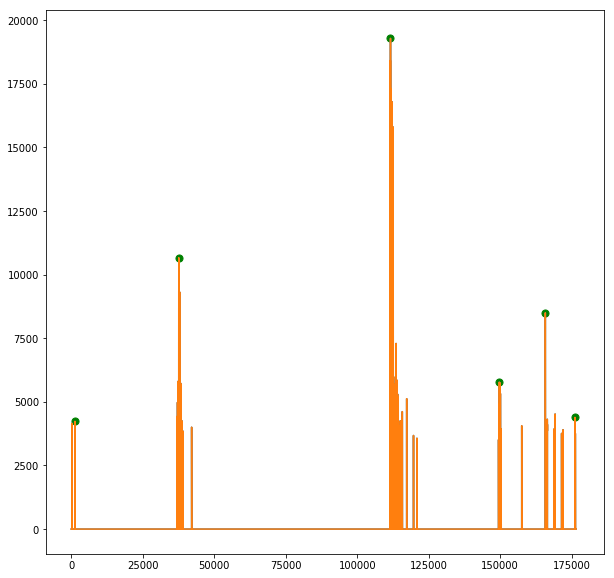

In [36]:
peaks, info = find_peaks(audio_defft[:,1], distance=10**4)
plt.figure(figsize=(10,10))
plt.plot(audio_defft)
plt.scatter(peaks, [audio_defft[i][0] for i in peaks], s = 50, color = "green")
plt.show()

#### There are thus a few problems that arise with the concept of strike detection:

* We do not know how many times the bat comes in contact with the ball in a certain video and thus cannot assume that `x` number of highest peaks are all strikes.
* Moreover, the highest peaks may not be strikes at all owing to sharp spikes due to clapping or a batsman gearing up by striking the bat against the pitch/ground.

Thus, we need to let the computer learn which sounds are attributed to a successful connection of a ball with a bat and the features of the sound associated with that. We need a network which learns to identify such a sound from a set of features extracted from the window.

__We use a `CNN` network with `MFCC` feature extraction to try and solve these issues.__

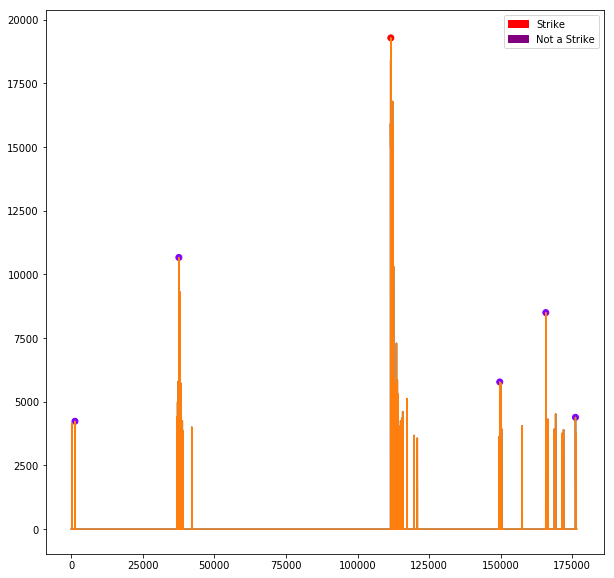

In [76]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='Strike')
purple_patch = mpatches.Patch(color="purple", label="Not a Strike")

labels = [0,0,1,0,0,0] # Manual Annotation based on Video
plt.figure(figsize=(10,10))
plt.plot(audio_defft)
plt.scatter(peaks, [audio_defft[i][0] for i in peaks], c = labels, cmap = "rainbow")
plt.legend(handles=[red_patch, purple_patch])
plt.show()

## Annotation of Window Labels

* We divide given audio sequence into windows of ~2 sec containing peaks obtained in time-series data. Thus, we obtain our input for training as well as testing of our CNN network later on.
* Remove comments to run on data needed to be annotated

In [2]:
def extract_windows(filename):
    # Read file given
    rate, audio = read(filename)
    print(rate)
    print(audio.shape)
    
    # Convert into frequency domain for noise reduction
    X = scipy.fft.fft(audio)
    X[X<7000] = 0 # Remove low frequency noise
    audio_defft = scipy.fft.ifft(X)
    audio_defft = np.real(scipy.fft.ifft(np.real(X))) # Convert back to time series
    
    # Extract peaks
    peaks, info = find_peaks(audio_defft[:,1], distance=10**5)
    
    # Plot peaks
    plt.figure(figsize=(50,50))
    plt.plot(audio_defft)
    plt.scatter(peaks, [audio_defft[i][0] for i in peaks])
    plt.show()
    
    # Extract Windows
    windows = list()
    for i in peaks:
        windows.append(audio_defft[i-40000:i+40000])

    # Save windows in .wav file format
    for i,win in enumerate(windows):
        win = np.asarray(win, dtype=np.int16)
        write("../outputs/"+filename[8:-4]+"_"+str(i)+".wav", rate, win)

In [3]:
def writetocsv(filename, labels):
    with open('../outputs/strikes.csv', 'a', newline='') as file:
        writer = csv.writer(file)
        for i, label in enumerate(labels):
            writer.writerow([filename[8:-4]+"_"+str(i)+".wav",label])

In [4]:
# extract_windows(files[5])

In [5]:
# writetocsv(files[5],[0,0,1,1,0,1,0,1])

## Read Windows and Sort Files

In [77]:
import glob, re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

features,files = list(), list()
for name in glob.glob('../outputs/*.wav'):
    files.append(name)
files.sort(key=natural_keys)

### Audio Properties

* __Other audio properties to consider:__
We may also need to consider normalising the volume levels (wave amplitude value) if this is seen
to vary greatly, by either looking at the peak volume or the RMS volume.

* __Normalize bit-depth and sampling rates also__

## Extracting MFCC

* Mel-Frequency Cepstral Coefficients (MFCC)
    
    * The MFCC summarises the frequency distribution across the window size, so it is possible to analyse both the frequency and
    time characteristics of the sound. These audio representations will allow us to identify features for classification.
    * MFCC values are not very robust in the presence of additive noise, and so it is common to normalise their values in speech  
    recognition systems to lessen the influence of noise.

In [78]:
max_pad_len = 174
def extract_features(file_name):
    '''
        Extract MFCC for audio windows annotated as above
    '''
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None
    return mfccs

pd_data = pd.read_csv('../outputs/strikes.csv')
print(pd_data.head())

           File  Label
0  audio1_0.wav      1
1  audio1_1.wav      0
2  audio2_1.wav      1
3  audio3_1.wav      1
4  audio3_2.wav      0


In [79]:
features = []

for index, row in pd_data.iterrows():
    
    file_name = "../outputs/" + row["File"]
    class_label = row["Label"]
    
    data = extract_features(file_name)
    
    features.append([data, class_label])

featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files')

Finished feature extraction from  85  files


In [99]:
from sklearn.model_selection import train_test_split

X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

## CNN Model Definition

* Will serve as feature extraction and binary classification
* The network structure is yet to be established but with a combination of MaxPool and 4 layers of Conv2D we get approx ~80% accuracy

In [100]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_rows = 40
num_columns = 174 # after padding

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, 1)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, 1)

num_labels = y.shape[0]
filter_size = 2

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(1, activation='sigmoid'))

In [101]:
# Compile the model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 39, 173, 16)       80        
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 19, 86, 16)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 19, 86, 16)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 18, 85, 32)        2080      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 9, 42, 32)         0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 9, 42, 32)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 8, 41, 64)         8256      
__________

## Training

In [102]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 100
num_batch_size = 10

# checkpointer = ModelCheckpoint(filepath='../saved_models/weights.best.basic_cnn.hdf5', 
#                                verbose=1, save_best_only=True)
start = datetime.now()

# model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
68/68 [==============================] - 3s 45ms/step - loss: 1.8526 - acc: 0.4559
Epoch 2/100
68/68 [==============================] - 0s 3ms/step - loss: 1.4973 - acc: 0.5588
Epoch 3/100
68/68 [==============================] - 0s 3ms/step - loss: 1.2221 - acc: 0.4706
Epoch 4/100
68/68 [==============================] - 0s 3ms/step - loss: 1.1374 - acc: 0.4853
Epoch 5/100
68/68 [==============================] - 0s 3ms/step - loss: 1.0835 - acc: 0.5000
Epoch 6/100
68/68 [==============================] - 0s 3ms/step - loss: 0.7159 - acc: 0.6324
Epoch 7/100
68/68 [==============================] - 0s 3ms/step - loss: 0.8833 - acc: 0.5735
Epoch 8/100
68/68 [==============================] - 0s 3ms/step - loss: 0.8267 - acc: 0.5294
Epoch 9/100
68/68 [==============================] - 0s 3ms/step - loss: 0.8993 - acc: 0.4706
Epoch 10/100
68/68 [==============================] - 0s 3ms/step - loss: 0.7527 - acc: 0.5735
Epoch 11/100
68/68 [==============================] - 0s 3

In [103]:
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9852941176470589
Testing Accuracy:  0.8235294222831726


## Improvements

* More data, including augmentations
* Test different architecture parameters
* Explore which .wav files lead to false positives and true negatives and augment data accordingly
* Spectogram analysis